# Consolidation

Check out the readme in this directory for further explanations

In [61]:
import alpaca_trade_api as tradeapi
import time
from datetime import datetime, timedelta
import pytz
tzET = pytz.timezone('US/Eastern')
import math

import matplotlib.pyplot as plt
plt.rcParams['timezone'] = 'US/Eastern'
import matplotlib.dates as mdates # for formatting dates in graph
import pandas as pd
import numpy as np

In [62]:
# returns public and secure key from alpaca and paper trading url
# these should really be stored securely in a different file
def getKeys():
  pub = 'PKJ0P4P4I3IKN3EM29U0'
  sec = 'x3FGUvHqQEGCHHAClL10O3C6Ywo6NGgmbwXtBmwp'
  url = 'https://paper-api.alpaca.markets' # in production remove 'paper-'
  return pub, sec, url

In [63]:
# starts up alpaca account and prints the portfolio cash
def initAlpaca():
  global api

  import alpaca_trade_api as tradeapi
  import websocket

  # START UP ACCOUNT
  public, secret, url = getKeys()
  api = tradeapi.REST(public, secret, url, api_version='v2')
  account = api.get_account()
  assert(account.status == 'ACTIVE')
  print('Account is active !')

In [64]:
# gets minute bars/candles for the stock with specific symbol between two iso dates
def getBarsForStockBetween(symbol, startIso, endIso):
  barset = api.get_barset(
    symbol, 
    'minute',
    start=startIso,
    end=endIso,
  )[symbol]
  for b in barset:
    b.t = b.t.astimezone(tzET)
  return barset

In [65]:
def roundDown(input, dp):
  factor = 10 ** dp
  return math.floor(input * factor)/factor

def roundUp(input, dp):
  factor = 10 ** dp
  return math.ceil(input * factor)/factor

In [66]:
# Consolidation is the object that plots:
#   funnel  - converging support and resistance. 
#   outcome - the closing price and trailing stop loss
# Consolidations are calculated each minute where one isn't in use. 
# Not every consolidation will have a trade entry
class Consolidation:
  def __init__(self, barsAll, nextTime, timeOutMins, periodHr):
    # note nextTime is the time just after consolidation so for 1st period
    # 9:31 - 10:30 nextTime would be 10:31

    self.startTime = nextTime - timedelta(hours=periodHr)
    startDay = self.startTime.replace(minute=31, hour=9)
    
    # if needed goes back to the correct start time so there is full consolidation 
    if self.startTime.isoformat() < startDay.isoformat():
      goBack = startDay - self.startTime
      prevDay = nextTime - timedelta(days=1)
      while prevDay.weekday() >= 5: # Monday is 0 and Sunday is 6, so if weekend
        prevDay = prevDay - timedelta(days=1)
      prevDay = prevDay.replace(minute=0, hour=16) - goBack
      self.startTime = prevDay

    self.endTime = nextTime - timedelta(minutes=1)
    self.timeOut = self.endTime + timedelta(minutes=timeOutMins)
    
    self.getBars(barsAll)
    if len(self.bars) < 5: # cant have 3 highs
      # print('less than 5 bars in this consolid') # todo this hapens alot... why?
      self.isUsing = False
    else:
      self.getFunnel()
  
  # bars included for the funnel
  def getBars(self, barsAll):
    self.bars = []
    i = 0
    while i < len(barsAll):
      bar = barsAll[i]
      if bar.t.isoformat() >= self.startTime.isoformat():
        if bar.t.isoformat() <= self.endTime.isoformat():
          self.bars.append(bar)
        else:
          break
      i += 1
  
  # the converging support and resistance 
  def getFunnel(self):
    highsList = [[bar.h, bar.t] for bar in self.bars]
    peaksList1 = self.getPeaksList(highsList)
    if len(peaksList1) < 3: # dont use if there arn't enough highs in the funnel
      self.isUsing = False
      return
    peaksList2 = list(peaksList1)
    while len(peaksList2) >= 3:
      peaksList1 = list(peaksList2)
      peaksList2 = self.getPeaksList(peaksList2)
    # now peaksList1 will be at least 3 points

    lowsList = [[bar.l, bar.t] for bar in self.bars]
    troughsList1 = self.getTroughsList(lowsList)
    if len(troughsList1) < 3: # dont use if there arn't enough lows in the funnel
      self.isUsing = False
      return
    troughsList2 = list(troughsList1)
    while len(troughsList2) >= 3:
      troughsList1 = list(troughsList2)
      troughsList2 = self.getTroughsList(troughsList2)
    # now troughsList1 will be at least 3 points
    
    self.resiXY, self.resiM, self.resiB, self.resiSumSquares = self.lineOfBestFit(peaksList1)
    self.suppXY, self.suppM, self.suppB, self.suppSumSquares = self.lineOfBestFit(troughsList1)
    
    # ATR: average true range (only for the funnel period)
    self.atr = 0
    n = len(self.bars)
    for i in range(1, n):
      prevBar = self.bars[i-1]
      currBar = self.bars[i]
      tr = max(
        currBar.h - currBar.l,
        abs(currBar.h - prevBar.c),
        abs(currBar.l - prevBar.c),
      )
      self.atr += tr
    self.atr /= n

    isConsolidating = self.suppM > self.resiM
    resiAcc = self.resiSumSquares / len(peaksList1)   / self.atr
    suppAcc = self.suppSumSquares / len(troughsList1) / self.atr
    
    isAccurate = resiAcc < 0.5 and suppAcc < 0.5
#     if self.bars[-1].t.isoformat() > self.endTime.isoformat() - timedelta(minutes=10)
#       print('self.suppM = ' + str(self.suppM) + 'self.resiM = ' + str(self.resiM))
#       print('resiAcc = ' + str(resiAcc) + 'suppAcc = ' + str(suppAcc))
#       print('isConsolidating = ' + str(isConsolidating))
#       print('isAccurate = ' + str(isAccurate))

    self.isUsing = isConsolidating and isAccurate
    
    if self.isUsing:

      # get buy limit
      def getBuyLimit(date):
        minutesDelay = (date - self.bars[-1].t).total_seconds() / 60
        resiCurrentPrice = self.resiM * minutesDelay + self.resiB
        suppCurrentPrice = self.suppM * minutesDelay + self.suppB
        diff = resiCurrentPrice - suppCurrentPrice
        if diff < 0:
          print('WARNING diff < 0') # todo check 18th may
        return suppCurrentPrice + 1.25 * diff
      self.getBuyLimit = getBuyLimit

      # get range out (when support meets resistance)
      self.rangeOut = self.endTime + timedelta(
        minutes=((self.resiB - self.suppB) / (self.suppM - self.resiM))
      )
    
  # returns a peaksList from a highsList both of form [peakPrice, timeET]
  def getPeaksList(self, highsList):
    n = len(highsList)

    peaksList = [] # list of: peakPrice timeET

    # manage left bar
    barC = highsList[0]
    barR = highsList[1]
    if barC[0] > barR[0]:
      peaksList.append(barC)
    
    # for the middle bars
    for i in range(1, n-1):
      barL = highsList[i-1]
      barC = highsList[i]
      barR = highsList[i+1]
      if barC[0] > barL[0] and barC[0] > barR[0]:
        peaksList.append(barC)

    # manage right bar
    barL = highsList[n-2]
    barC = highsList[n-1]
    if barC[0] > barL[0]:
      peaksList.append(barC)

    return peaksList
  
  # returns a troughsList from a lowsList both of form [troughPrice, timeET]
  def getTroughsList(self, lowsList):
    n = len(lowsList)

    troughsList = [] # list of: troughPrice timeET

    # manage left bar
    barC = lowsList[0]
    barR = lowsList[1]
    if barC[0] < barR[0]:
      troughsList.append(barC)

    # for the middle bars
    for i in range(1, n-1):
      barL = lowsList[i-1]
      barC = lowsList[i]
      barR = lowsList[i+1]
      if barC[0] < barL[0] and barC[0] < barR[0]:
        troughsList.append(barC)
    
    # manage right bar
    barL = lowsList[n-2]
    barC = lowsList[n-1]
    if barC[0] < barL[0]:
      troughsList.append(barC)

    return troughsList

  # takes a list of points [price, timeET].
  def lineOfBestFit(self, pointsList):

    n = len(pointsList)
    recentDateTime = pointsList[-1][1]

    X = [(point[1] - recentDateTime).total_seconds() / 60 for point in pointsList]
    Y = [point[0] for point in pointsList]

    sumX = 0
    for x in X:
      sumX += x
    # print('sumX = ' + str(sumX))

    sumY = 0
    for y in Y:
      sumY += y
    # print('sumY = ' + str(sumY))

    meanX = sumX / n
    meanY = sumY / n
    # print('meanX = ' + str(meanX))
    # print('meanY = ' + str(meanY))

    diffX = [i*(x - meanX) for i, x in enumerate(X)]
    diffY = [i*(y - meanY) for i, y in enumerate(Y)]
    
    prodDiff = [diffX[i] * diffY[i] for i in range(0, n)]
    sqrDiff = [diffX[i] * diffX[i] for i in range(0, n)]

    sumProdDiff = 0
    for element in prodDiff:
      sumProdDiff += element
    # print('sumProdDiff = ' + str(sumProdDiff))

    sumSqrDiff = 0
    for element in sqrDiff:
      sumSqrDiff += element
    # print('sumSqrDiff = ' + str(sumSqrDiff))

    m = sumProdDiff / sumSqrDiff
    b = meanY - m * meanX

    lineXY = [
      [recentDateTime + X[0] * timedelta(minutes=1), recentDateTime], # Y old -> new
      [m * X[0] + b, b] # Y old -> new
    ]
    
    # residual
    sumSquares = 0
    for i in range(0, n):
      x = X[i]
      y = Y[i]

      bestY = m * x + b
      diff = bestY-y
      sumSquares += (diff * diff)
    # print(sumSquares)

    return lineXY, m, b, sumSquares

  # time close loss
  def newCloseStopPrices(self, arr):
    self.closeStopList = [arr]

  def addCloseStopPrice(self, bar):
    loss = self.closeStopList[-1][2]
    lastClose = self.closeStopList[-1][1]
    if bar.c - lastClose > 0:
      loss += bar.c - lastClose
    self.closeStopList.append([
      bar.t,
      bar.c,
      loss
    ])
    return bar.c < loss, loss

  def plot(self, ax):
    # funnel
    ax.plot(self.resiXY[0], self.resiXY[1], 'pink')
    ax.plot(self.suppXY[0], self.suppXY[1], 'purple')

    # outcome (close-stop line)
    datetimes = [cs[0] for cs in self.closeStopList]
    closes = [cs[1] for cs in self.closeStopList]
    stops = [cs[2] for cs in self.closeStopList]
    outcomeColour = 'green' if closes[-1] > closes[0] else 'black'
    ax.plot(datetimes, closes, outcomeColour)
    ax.plot(datetimes, stops, 'orange')

In [67]:
def candlePlotConsolidation(barsAll, boughtConsolidations, isDrawingCandles, title):

  fig, ax = plt.subplots(2, sharex=True, figsize=(14, 7))
  fig.suptitle(title, fontsize=20)

  totalDF, stockDF, flatXY = getTopChartDFs(10000, barsAll, boughtConsolidations)
  ax[0].plot(totalDF.time, totalDF.total, color='green')
  ax[0].plot(stockDF.time, stockDF.stock, color='blue')
  ax[0].plot(flatXY[0], flatXY[1], color='black')

  listDates = []
  for b in barsAll:
    listDates.append(b.t)

  # CANDLES
  if isDrawingCandles:

    listOpen = []
    listClose = []
    listHigh = []
    listLow = []
    
    for b in barsAll:
      listOpen.append(b.o)
      listClose.append(b.c)
      listHigh.append(b.h)
      listLow.append(b.l)

    prices = pd.DataFrame(index=listDates)
    prices['Open'] = listOpen
    prices['High'] = listHigh
    prices['Low'] = listLow
    prices['Close'] = listClose

    pricesup=prices[prices.Close>=prices.Open]
    pricesdown=prices[prices.Close<prices.Open]
    
    # chosing a divisor for candlewidth is hard. Try:
    # 30 good for 6months 
    # 3 good for 1 month
    # 12 good for 2h
    width=0.9  * (1 / prices.shape[0]) / 12
    width2=0.1  * (1 / prices.shape[0]) / 12 

    # plot the candles
    # green
    greenBarheight = [] # bar has a minimum thickness to ensure it shows up
    for index, row in pricesup.iterrows():
      height = row.Close - row.Open
      if height < 0.01 and height > -0.01:
        height = 0.01
      greenBarheight.append(height)
    ax[1].bar(pricesup.index, greenBarheight, width, bottom=pricesup.Open, color='g')
    ax[1].bar(pricesup.index, pricesup.High - pricesup.Low, width2, bottom=pricesup.Low, color='g')
    # red
    redBarheight = []
    for index, row in pricesdown.iterrows():
      height = row.Close - row.Open
      if height < 0.01 and height > -0.01:
        height = 0.01
      redBarheight.append(height)
    ax[1].bar(pricesdown.index, redBarheight, width, bottom=pricesdown.Open, color='r')
    ax[1].bar(pricesdown.index, pricesdown.High - pricesdown.Low, width2, bottom=pricesdown.Low, color='r')

  # CONSOLIDATIONS
  isDrawingConsolidations = True
  if isDrawingConsolidations:
    for c in boughtConsolidations:
      c.plot(ax[1])
  
  # max 40 ticks
  listDatesForTicks = []
  if len(listDates) > 40:
    tickFreq = roundUp(len(listDates) / 40, 0)
    for i, date in enumerate(listDates):
      if i % tickFreq == 0:
        listDatesForTicks.append(date)
  else:
    listDatesForTicks = listDates
  plt.xticks(listDatesForTicks)

  ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %I:%M %p'))
  plt.xticks(rotation=90)
  fig.tight_layout()

  plt.grid()
  plt.show()

In [68]:
def getTopChartDFs(initialCash, barsAll, boughtConsolidations):
  initialCash = 10000
  
  # total
  total = initialCash
  timeTotalList = []
  timeTotalList.append([barsAll[0].t, total])
  for c in boughtConsolidations:
    initialClose = c.closeStopList[0][1]
    initialTotal = total
    for timeCloseStop in c.closeStopList:
      
      nextClose = timeCloseStop[1]
      total = initialTotal * (nextClose / initialClose)
      timeTotalList.append([timeCloseStop[0], total])
      
  # once all consolidations are plotted, plot the final total to finish drawing the graph
  timeTotalList.append([barsAll[-1].t, total])
  totalDF = pd.DataFrame(timeTotalList, columns=['time', 'total'])
  # print('totalDF = ')
  # print(totalDF)
  
  # stock
  stock = initialCash
  stockTimePrice = []
  stockTimePrice.append([barsAll[0].t, stock])
  barLInv = 1 / barsAll[0].c
  for i in range(1, len(barsAll)):
    barR = barsAll[i]
    closeToOpen = barR.c * barLInv
    stock = closeToOpen * initialCash
    stockTimePrice.append([barR.t, stock])
  stockDF = pd.DataFrame(stockTimePrice, columns=['time', 'stock'])
  # print('stockDF = ')
  # print(stockDF)
  
  # flat
  flatXY = [[barsAll[0].t, barsAll[-1].t], [initialCash, initialCash]]

  return totalDF, stockDF, flatXY

In [71]:
def consolidationStrategy(symbol, startDay, endDay, minDelay, hrConsolidation, candlesOn):
  
  startDayTime = startDay.replace(minute=31, hour=9)
  startIso = startDayTime.isoformat()
  endDayTime = endDay.replace(minute=0, hour=16)
  endIso = endDayTime.isoformat()

  # GET BARS FROM api
  barsAll = getBarsForStockBetween(symbol, startIso, endIso)

  # get the first bar of the day after 11:30 (11:31)
  i = 0
  time = barsAll[i].t.isoformat()
  while time < (startDayTime + timedelta(hours=hrConsolidation)).isoformat():
    i += 1
    time = barsAll[i].t.isoformat()
  consolid = None

  isBought = False
  boughtConsolidations = []
  # main loop
  while i < len(barsAll):
    bar = barsAll[i]
    print('  last min candle processed at: ' + str(bar.t), end='\r')

    if isBought:
      isSelling, lossPrice = consolid.addCloseStopPrice(bar)
      if isSelling:
        # SELL
        boughtConsolidations.append(consolid)
        consolid = None
        isBought = False

    if not isBought: # not 'else' as, if no longer bought try again now
      
      if consolid == None:
        consolid = Consolidation(barsAll, bar.t, 30, hrConsolidation)
      if not consolid.isUsing:
        # print('reconsolidate but not using')
        consolid = None

      if not consolid == None:
        # consolidation is good!
        isRangeOut = bar.t.isoformat() > consolid.rangeOut.isoformat()
        isTimeOut  = bar.t.isoformat() > consolid.timeOut.isoformat()
        if isRangeOut or isTimeOut: # if range has closed or time has expired
          consolid = None
        else:
          # in possible breakout time and range
          # check to see if you should buy the breakout

          buyPrice = consolid.getBuyLimit(bar.t)
          if bar.c > buyPrice:
            # BUY
            stopLoss = buyPrice - 8 * consolid.atr
            consolid.newCloseStopPrices([
              bar.t,
              buyPrice,
              stopLoss
            ])
            isBought = True
    i += 1
  
  # add the final consolid if current position is long
  if isBought:
    boughtConsolidations.append(consolid)

  candlePlotConsolidation(barsAll, boughtConsolidations, True, symbol) 

This next cell shows the consolidation strategy for a particular day (7th April 2020) as this day clearly shows the candles and has two nice consolidation periods.

Account is active !


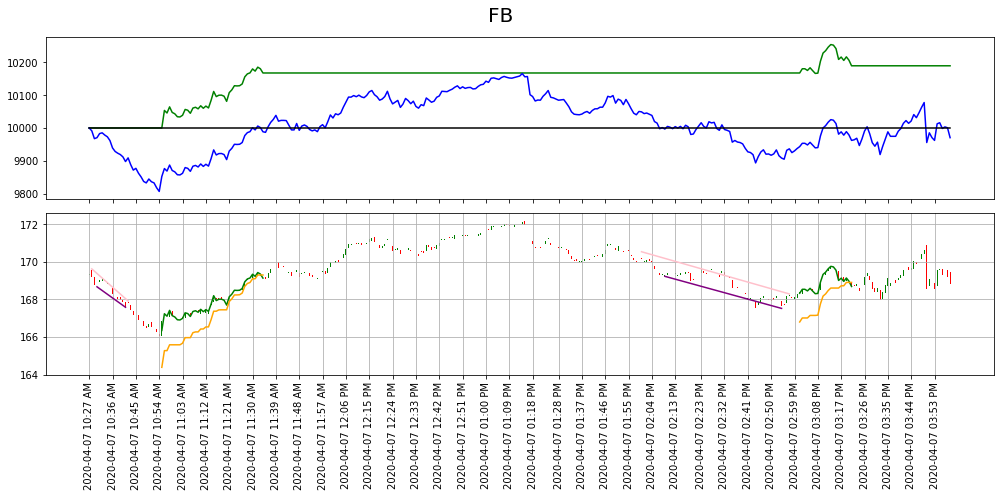

In [72]:
initAlpaca()
consolidationStrategy(
  'FB',
  datetime(2020, 4, 7, tzinfo=tzET),
  datetime(2020, 4, 7, tzinfo=tzET),
  5, # delay min
  1, # consolidation period hrs
  True, # candles On?
)

This next cell takes 19 minutes to run but runs roughly over Q1 of 2020. The last cell in candles.ipynb is also roughly over Q1 of 2020 and had maximum profit of $3035 (3 red 2 green but that would be a lot of commission). The graph below shows that consolidation strategy can give a profit of ~4000 (slightly more) and also does this in less trades (less commission). Also note this is a recession period

Account is active !


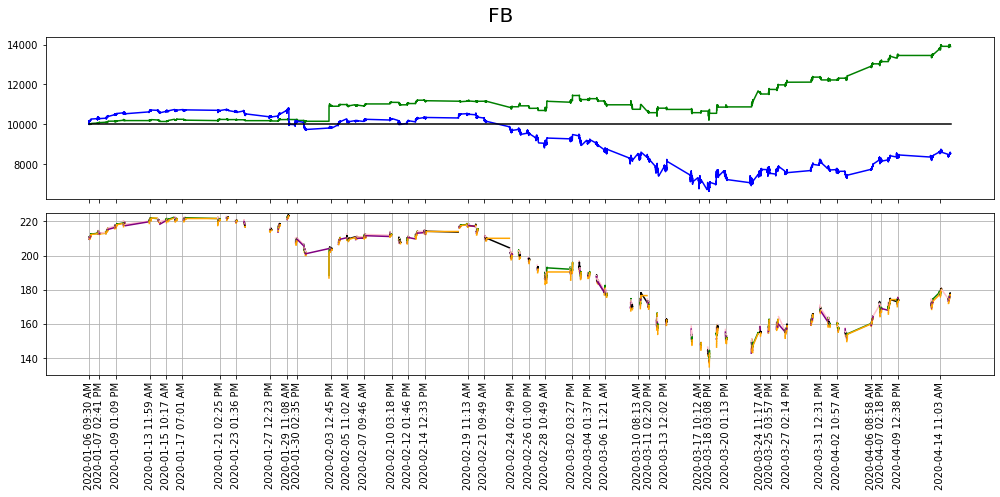

In [74]:
initAlpaca()
consolidationStrategy(
  'FB',
  datetime(2020, 1,  6, tzinfo=tzET),
  datetime(2020, 4, 15, tzinfo=tzET),
  5, # delay min
  1, # consolidation period hrs
  False, # candles On?
)